# full migrate code workflow

Full workflow of migrate legacy code into modren one

- [parsing](#parsing)
- [code understanding](#code_understanding)
- [reverse engingeering](#reverse_engineering)
- [code generation](#code_generation)
- 
<center>
    <img src="../assets/how.png" alt="how">
</center>


## parsing

In [1]:
import os
import sys
import json

# Use the current working directory instead of __file__
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..','parser'))

# Add the parent directory to sys.path
sys.path.append(parent_dir)

from antlr4 import *
from cobol85.Cobol85Lexer import Cobol85Lexer
from cobol85.Cobol85Parser import Cobol85Parser

print("Import Successful!")

Import Successful!


In [2]:
input_code = """
IDENTIFICATION DIVISION.
PROGRAM-ID. EXAMPLE.
DATA DIVISION.
WORKING-STORAGE SECTION.
77  NUM         PICTURE 99.
77  QUOTIENT    PICTURE 99.
77  REMAIN      PICTURE 9.
PROCEDURE DIVISION.
   ACCEPT NUM.
   DIVIDE NUM BY 2 GIVING QUOTIENT REMAINDER REMAIN.
   IF REMAIN = 0
           DISPLAY NUM ' IS EVEN'
   ELSE
           DISPLAY  NUM ' IS ODD'
   END-IF.
   STOP RUN.
"""

lexer = Cobol85Lexer(InputStream(input_code))
stream = CommonTokenStream(lexer)
parser = Cobol85Parser(stream)

tree = parser.startRule()

## code_understanding

In [4]:
from cobol85.CobolCFGListener import CobolCFGListener

In [5]:
cfg_listener = CobolCFGListener()
walker = ParseTreeWalker()
walker.walk(cfg_listener, tree)

cfg_listener.add_end_node()

In [6]:
data = {
    "nodes": cfg_listener.nodes,
    "edges": cfg_listener.edges,
}

# export json file for visualize
with open('cfg.json', 'w') as f:
    json.dump(data, f)

In [12]:
data

{'nodes': [{'id': '1', 'data': {'label': 'start'}},
  {'id': '2', 'data': {'label': 'ACCEPT NUM\n'}},
  {'id': '3', 'data': {'label': 'DIVIDE NUM BY 2 REMINDER REMAIN\n'}},
  {'id': '4', 'data': {'label': 'IF REMAIN=0\n'}},
  {'id': '5', 'data': {'label': "DISPLAY NUM ' IS EVEN'\n"}},
  {'id': '6', 'data': {'label': "DISPLAY NUM ' IS ODD'\n"}},
  {'id': '7', 'data': {'label': 'End If'}},
  {'id': '8', 'data': {'label': 'stop'}}],
 'edges': [{'id': '2',
   'source': '1',
   'target': '2',
   'label': 'sequential next'},
  {'id': '3', 'source': '2', 'target': '3', 'label': 'sequential next'},
  {'id': '4', 'source': '3', 'target': '4', 'label': 'sequential next'},
  {'id': '5', 'source': '4', 'target': '5', 'label': 'true'},
  {'id': '6', 'source': '4', 'target': '6', 'label': 'false'},
  {'id': '7', 'source': '5', 'target': '7', 'label': 'sequential next'},
  {'id': '7', 'source': '6', 'target': '7', 'label': 'sequential next'},
  {'id': '8', 'source': '7', 'target': '8', 'label': 'sequ

In [9]:
# visualize json file
!python ../utils/visualize_cfg.py cfg.json

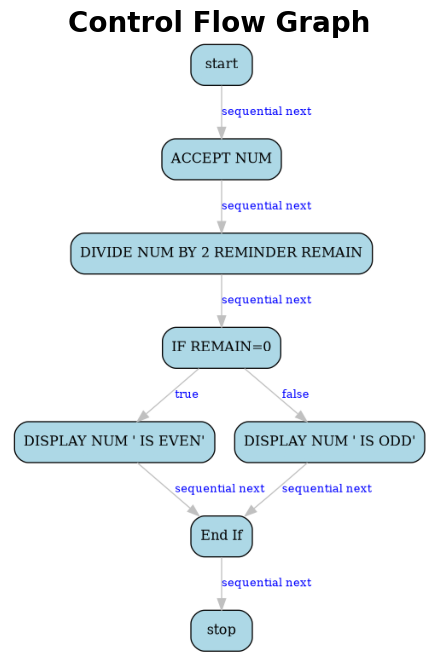

In [17]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the image
img = mpimg.imread('cfg.png')  # Replace with your image path

# Create a figure with a specified size
plt.figure(figsize=(10, 8))

# Display the image with a fancy colormap (optional)
plt.imshow(img, cmap='viridis')  # You can change 'viridis' to any other colormap

# Add a title to the image
plt.title('Control Flow Graph', fontsize=20, fontweight='bold')

# Hide the axes for a cleaner look
plt.axis('off')

# Show the image
plt.show()


In [18]:
# Convert JSON object to string
parsed_data = json.dumps(data, indent=4)  # indent for pretty printing
print(parsed_data)

{
    "nodes": [
        {
            "id": "1",
            "data": {
                "label": "start"
            }
        },
        {
            "id": "2",
            "data": {
                "label": "ACCEPT NUM\n"
            }
        },
        {
            "id": "3",
            "data": {
                "label": "DIVIDE NUM BY 2 REMINDER REMAIN\n"
            }
        },
        {
            "id": "4",
            "data": {
                "label": "IF REMAIN=0\n"
            }
        },
        {
            "id": "5",
            "data": {
                "label": "DISPLAY NUM ' IS EVEN'\n"
            }
        },
        {
            "id": "6",
            "data": {
                "label": "DISPLAY NUM ' IS ODD'\n"
            }
        },
        {
            "id": "7",
            "data": {
                "label": "End If"
            }
        },
        {
            "id": "8",
            "data": {
                "label": "stop"
            }
        }


In [21]:
from openai import OpenAI

with open("/home/loc/Documents/keys/OPENAI_API_KEY.txt") as f:
    OPENAI_API_KEY = f.read().strip()
    
client = OpenAI(api_key=OPENAI_API_KEY)

# Function to prompt the LLM
def generate_report(parsed_data):
    prompt = (
        f"Create a report explaining how this code functions based on the provided control flow graph JSON:\n {parsed_data}."
    )
    
    response = client.chat.completions.create(
                messages=[{
                    "role": "user",
                    "content": prompt,
                }],
                model="gpt-4o-mini",
            )

    
    return response.choices[0].message.content

report = generate_report(parsed_data)
print(report)

### Report: Functionality of the Provided Code Based on Control Flow Graph

This report outlines the functionality of the given code based on its control flow graph representation. The graph is composed of nodes, each representing a distinct step or state in the process, and directed edges that indicate the flow from one state to another. 

#### Code Execution Flow

1. **Start Node (ID: 1)**:
   - The code execution begins at the "start" node. This node signifies the entry point of the program, where the process is initiated.

2. **Accept Number (Node ID: 2)**:
   - The execution moves to the second node where it waits for an input: "ACCEPT NUM". The user is expected to provide a numerical value that will be processed subsequently.

3. **Divide Number by 2 and Calculate Remainder (Node ID: 3)**:
   - After successfully accepting the number, the program transitions to node 3, where it performs the following operation: "DIVIDE NUM BY 2 REMAINDER REMAIN". Here, the input number is divided

## reverse_engineering

In [31]:
request_template = f"This is the report that describes how the code operates, please write the equivalent functionality in Java.\n{report}"

request = request_template.format(report=report)
print(request)

This is the report that describes how the code operates, please write the equivalent functionality in Java.
### Report: Functionality of the Provided Code Based on Control Flow Graph

This report outlines the functionality of the given code based on its control flow graph representation. The graph is composed of nodes, each representing a distinct step or state in the process, and directed edges that indicate the flow from one state to another. 

#### Code Execution Flow

1. **Start Node (ID: 1)**:
   - The code execution begins at the "start" node. This node signifies the entry point of the program, where the process is initiated.

2. **Accept Number (Node ID: 2)**:
   - The execution moves to the second node where it waits for an input: "ACCEPT NUM". The user is expected to provide a numerical value that will be processed subsequently.

3. **Divide Number by 2 and Calculate Remainder (Node ID: 3)**:
   - After successfully accepting the number, the program transitions to node 3, wher

## code_generation

In [34]:
# Function to prompt the LLM
def generate_code(request):

    response = client.chat.completions.create(
                messages=[
                    {"role": "system",
                     "content": "Your task is to generate Java code based on the provided request. Ensure that your response includes only the code.",
                    },
                    {"role": "user",
                    "content": request,
                    },
                ],
                model="gpt-4o-mini",
            )

    
    return response.choices[0].message.content

code = generate_code(request)
print(code)

```java
import java.util.Scanner;

public class EvenOddChecker {
    public static void main(String[] args) {
        // Start Node
        Scanner scanner = new Scanner(System.in);
        
        // Accept Number (Node ID: 2)
        System.out.print("ACCEPT NUM: ");
        int num = scanner.nextInt();

        // Divide Number by 2 and Calculate Remainder (Node ID: 3)
        int remainder = num % 2;

        // Check if the Remainder is Zero (Node ID: 4)
        if (remainder == 0) {
            // DISPLAY NUM ' IS EVEN' (Node ID: 5)
            System.out.println(num + " IS EVEN");
        } else {
            // DISPLAY NUM ' IS ODD' (Node ID: 6)
            System.out.println(num + " IS ODD");
        }

        // End Conditional Check (Node ID: 7)

        // Stop Node (Node ID: 8)
        scanner.close();
    }
}
```


## direct_migration

In [36]:
# Function to prompt the LLM
def migrate_code(input_code):

    response = client.chat.completions.create(
                messages=[
                    {"role": "system",
                     "content": "Please convert the following COBOL code into Java.\
                                 Ensure that the functionality is preserved and that the Java code follows best practices \
                                 and your response includes only the code",
                    },
                    {"role": "user",
                    "content": request,
                    },
                ],
                model="gpt-4o-mini",
            )

    
    return response.choices[0].message.content

code = migrate_code(input_code)
print(code)

```java
import java.util.Scanner;

public class EvenOddChecker {
    public static void main(String[] args) {
        Scanner scanner = new Scanner(System.in);
        
        // Step 1: Accept Number
        System.out.print("Enter a number: ");
        int num = scanner.nextInt();
        
        // Step 2: Divide Number by 2 and Calculate Remainder
        int remain = num % 2;
        
        // Step 3: Check if the Remainder is Zero
        if (remain == 0) {
            // Step 4: Display Result if Even
            System.out.println(num + " is even.");
        } else {
            // Step 5: Display Result if Odd
            System.out.println(num + " is odd.");
        }
        
        // Step 6: Closing scanner
        scanner.close();
        
        // Step 7: Program termination
    }
}
```
